# Data Scraping with Twint Library

Twint allows scraping Tweets from Twitter profiles **without** using Twitter's API (which has a limitation at 3200 Tweets).

Twint utilizes Twitter's search operators to let us scrape Tweets from specific users, scrape Tweets relating to certain topics, hashtags & trends, or sort out sensitive information from Tweets like e-mail and phone numbers. We find this very useful, as it also allow us to get really creative with it too.

Twint also makes special queries to Twitter allowing you to also scrape a Twitter user's followers, Tweets a user has liked, and who they follow without any authentication, API, Selenium, or browser emulation.

Requirements:
- Python 3.6;
- aiohttp;
- aiodns;
- beautifulsoup4;
- cchardet;
- dataclasses
- elasticsearch;
- pysocks;
- pandas (>=0.23.0);
- aiohttp_socks;
- schedule;
- geopy;
- fake-useragent;
- py-googletransx.

In [4]:
#importing basic libraries
import numpy as np   #linear algebra
import pandas as pd  #data processing
import matplotlib.pyplot as plt   #library for plots 
import re            #rejex library

In [ ]:
from google.colab import drive  #mounting google drive
drive.mount("/content/drive")

In [ ]:
%cd /content/drive/MyDrive/1-UniVE/Assignment Data

/content/drive/MyDrive/1-UniVE/Assignment Data


In [ ]:
#Installing Twint
#worked method <- solves problems of CriticalError
!pip3 install twint
!pip3 uninstall twint -y
!pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint

In [ ]:
#check if the twint packege is present (COLAB)
!ls '/root/.local/lib/python3.7/site-packages/twint/'

cli.py	     feed.py	__init__.py  run.py    tweet.py  verbose.py
config.py    format.py	output.py    storage   url.py	 __version__.py
datelock.py  get.py	__pycache__  token.py  user.py


### Problem fixing
Twint can present various errors caused by changes from Twitter which are in conflict with the library, with these modifications we can avoid some of them.

1. move a modified version of "url.py" to Twint library. It has line 92 uncommented, without this change the script would stop before scraping all the Tweets.
2. fixed version of "token.py", solution for "RefreshTokenException('Could not find the Guest token in HTML')"

To move the files to Twint library we use the function **copy(source path, destination path)** from **shutil** module.
- source path = *url.py* path
- destination path = Twint library directory

In [ ]:
#Fixing problems (JUPYTER VERSION)

#Abbreviation of the address - Jupyter
drive = "D:/Il mio Drive/1-UniVE/Laurea Magistrale - Data Analytics for Business and Society/Computer Programming and Data Management/II part/Assignment/Fixed files/"  #<- change directory to your path

from shutil import copy
copy(drive + "url.py", 'C:/Users/lucax/AppData/Roaming/Python/Python38/site-packages/twint')  #<- change directory to your path
copy(drive + "token.py", "C:/Users/lucax/AppData/Roaming/Python/Python38/site-packages/twint") #<- change directory to your path

'C:/Users/lucax/AppData/Roaming/Python/Python38/site-packages/twint\\token.py'

In [ ]:
#Fixing problems (COLAB VERSION) 

#just an abbreviation of the address - Colab
drive = "/content/drive/My Drive/1-UniVE/Laurea Magistrale - Data Analytics for Business and Society/Computer Programming and Data Management/II part/Assignment/Fixed files/" #<- change directory to your path

from shutil import copy
copy(drive + "url.py", "/root/.local/lib/python3.7/site-packages/twint/") #<- change directory to your path
copy(drive + "token.py", "/root/.local/lib/python3.7/site-packages/twint/") #<- change directory to your path

'/root/.local/lib/python3.7/site-packages/twint/token.py'

### Using Twint library

In [ ]:
#importing Twint library 
import twint

import nest_asyncio     
nest_asyncio.apply() 
#with the last two lines eliminate error when running twint of: 
#        RuntimeError: This event loop is already running
#        CRITICAL:root:twint.get:User:'NoneType' object is not subscriptable

The *data_scraping* function below looks for the keywords: **vaccini, vaccinazioni, vaccino** or **vaccinazione** using twint library.

With *Since* and *Until* we configure the timeframe in which we want to scrape data; below we have a test interval.

For scraping our dataset we used 4 intervals:
- c.Since = "2021-10-01" and c.Until = "2021-12-22" -> twitter_scraping 10-12.csv, datas of October to December 22nd
- c.Since = "2021-08-01" and c.Until = "2021-09-30" -> twitter_scraping 08-09.csv, datas of August and September
- c.Since = "2021-06-01" and c.Until = "2021-07-31" -> twitter_scraping 06-07.csv, datas of June and July
- c.Since = "2021-04-01" and c.Until = "2021-05-31" -> twitter_scraping 04-05.csv, datas of April, May
- c.Since = "2021-03-01" and c.Until = "2021-03-31" -> twitter_scraping 03.csv, datas of March

We divided 4 intervals because the dataset was too large to scrape in one go, and could interrupt for unknown reasons.

We turn Hide_output to True otherwise it would return at the output a line about every Tweet we scraped and it would slow down the computer.

*Resume* creates a txt file in which a *scroll ID* is stored, so when the script interrupts you can restart from the last element in the resume file instead of starting over.

In [ ]:
def data_scraping():
  c = twint.Config()
  c.Search = "vaccini OR vaccinazioni OR vaccino OR vaccinazione"  #keywords
  # c.Popular_tweets = True
  c.Lang = "it"             #doesn't fully work
  c.Since = "2021-12-23"    #modifying this interval we control the time period of tweets we want to scrap
  c.Until = "2021-12-25"
  c.Pandas = True
  c.Store_csv = True
  c.Output = "test_twitter_scraping.csv"  
  c.Hide_output = True  #hiding ouput -> it may slow down the system
  c.Count = True
  c.Resume = 'test_resume file.txt' 
    #important if you have to scrape data when errors occurs or you scrape in different times,
    #it gives a code to each tweet and resumes from the last code
  twint.run.Search(c)

Sometime the script can give errors by scraping only few tweets and say there are no more data available or lose connection with peer.

With this simple loop we work around this problem.

We set the loop at 50 because it's a reasonable number of loops after which we can confirm that it finished scraping 
(if *[!] No more data!* are returned).
If we see from the results that shows it bypassed errors for more than 50 times without scraping it means that it is a persistent error caused by some serverside changes made by Twitter so we will have to wait for updates or look for solutions.

In [ ]:
#sometime the script can give errors by scraping only few tweets and say there are no more data available or lose connection with peer
#with this simple loop we workaround that problem
bypass = 0
finished = 0
while finished < 50: #if it shows that there are 0 tweets for 50 times we can be sure that tweets are finished
  try:
    data_scraping()
    finished += 1
    print("finished scraping", finished, " times.")
  except:
    bypass += 1
    print("bypassed errors :", bypass)
    if bypass > 50:    #if the same error returns 50 times we can know that it's not a temporary error so we have to check it
      break

bypassed errors : 1
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 19115 Tweets.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 4107 Tweets.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 509 Tweets.
finished scraping 1  times.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets.
finished scraping 2  times.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets.
finished scraping 3  times.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finished: Successfully collected 0 Tweets.
finished scraping 4  times.
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
[+] Finish

Now we load the datas of the tweets and create a single dataframe that we call tweets.

In [ ]:
#loading tweets datasets  -- COLAB
drive = '/content/drive/My Drive/1-UniVE/Laurea Magistrale - Data Analytics for Business and Society/Computer Programming and Data Management/II part/Assignment/'
#drive is made to call the path to the file simpler
tweets_1 = pd.read_csv(drive + "twitter_scraping 03.csv", low_memory=False)  #data from march
tweets_2 = pd.read_csv(drive + "twitter_scraping 04-05.csv", low_memory=False) #data from aprile - may
tweets_3= pd.read_csv(drive + "twitter_scraping 06-07.csv", low_memory=False)  #data from june - july
tweets_4 = pd.read_csv(drive + "twitter_scraping 08-09.csv", low_memory=False) #data from august - september
tweets_5 = pd.read_csv(drive + "twitter_scraping 10-12.csv", low_memory=False) #data from october - december

In [4]:
#loading tweets datasets  -- JUPYTER

tweets_1 = pd.read_csv("twitter_scraping 03.csv", low_memory=False)  #data from march
tweets_2 = pd.read_csv("twitter_scraping 04-05.csv", low_memory=False) #data from aprile - may
tweets_3= pd.read_csv("twitter_scraping 06-07.csv", low_memory=False)  #data from june - july
tweets_4 = pd.read_csv("twitter_scraping 08-09.csv", low_memory=False) #data from august - september
tweets_5 = pd.read_csv("twitter_scraping 10-12.csv", low_memory=False) #data from october - december

In [5]:
tweet_datasets = [tweets_5, tweets_4, tweets_3, tweets_2, tweets_1]
#concatenate so the data follows chronologically
tweets = pd.concat(tweet_datasets)
tweets

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1473443151146803204,1473401732587823111,2021-12-21 23:59:57 UTC,2021-12-21,23:59:57,0,1699728120,argentofisico,Er,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'DiegoFusaro', 'name': 'Diego...",NaN,NaN,NaN,NaN
1,1473443030434779136,1473443030434779136,2021-12-21 23:59:28 UTC,2021-12-21,23:59:28,0,1052650359217360901,dilio_bianchi,dilio bianchi,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1473442968979787776,1473442968979787776,2021-12-21 23:59:13 UTC,2021-12-21,23:59:13,0,1117755210225549312,fcatinelli,king zulu king 🏴‍☠️,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1473442894388338698,1473440068211724294,2021-12-21 23:58:55 UTC,2021-12-21,23:58:55,0,2753154182,cris_cersei,Cristina Cersei,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'AlessandroPeir4', 'name': 'A...",NaN,NaN,NaN,NaN
4,1473442666704687108,1472527096568328197,2021-12-21 23:58:01 UTC,2021-12-21,23:58:01,0,1228053389470261248,democrazia,+ Democrazia,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'stanzaselvaggia', 'name': 'S...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406998,1366177190442844161,1366177190442844161,2021-03-01 00:03:19 UTC,2021-03-01,00:03:19,0,487406587,vincenzacrisci,vincenza crisci iofaroil vaccino,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
406999,1366177017528545287,1365927800667070464,2021-03-01 00:02:37 UTC,2021-03-01,00:02:37,0,350791815,ivanopaterno,Ivano IU3EGX,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'filippo28155236', 'name': '🇮...",NaN,NaN,NaN,NaN
407000,1366176754197479444,1366176754197479444,2021-03-01 00:01:35 UTC,2021-03-01,00:01:35,0,370639956,pillapaladini,trust the plan no DM,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
407001,1366176481123180546,1366176481123180546,2021-03-01 00:00:30 UTC,2021-03-01,00:00:30,0,997465047675932672,ro_ber_ta__,Roberta🥁🌼🐈🎈,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [6]:
tweets.to_csv("tweets full df.csv", index = False)

## Data Processing

Working with a huge dataset with 3 million rows slows down the pc so we consider only the "relevant tweets" with more than 100 likes.
This way we can shrink the datasize to 39430 tweets.

We load only a partition of the data without columns containing NaNs and irrelevant info.

In [8]:
tweets = pd.read_csv("tweets full df.csv", low_memory=False, 
            usecols=["date", "time", "username", "tweet", "mentions", "replies_count", "retweets_count", "likes_count", "hashtags", "language"])

In [11]:
tweets = tweets[(tweets["likes_count"]>100)] 
tweets.head(5)

,date,time,username,tweet,language,mentions,replies_count,retweets_count,likes_count,hashtags
45,2021-12-21,23:47:42,cris_cersei,Cmq forzare la gente al vaccino sterminando se...,it,[],14,97,465,[]
77,2021-12-21,23:37:18,astramezzi,"Coronavirus, Israele annuncia inoculazione qua...",it,[],64,325,856,[]
99,2021-12-21,23:30:45,gavinosanna1967,- Col nuovo vaccino niente più scuse per i no ...,it,[],56,206,1208,[]
148,2021-12-21,23:17:15,vitalbaa,Dopo mesi passati a contrapporre vaccino e tam...,it,[],31,49,383,[]
217,2021-12-21,22:59:08,christian_fsi,Oh! Finalmente è uscito il #Novavax. Un altro ...,it,[],16,44,231,['novavax']


In [161]:
#we save the dataset a lot in order to avoid reloading the entire dataset
tweets.to_csv("tweets_100.csv", index = False)

In [162]:
tweets = pd.read_csv("tweets_100.csv")

In [12]:
print(tweets.language.unique(),
"\n total italian tweets:", sum(tweets["language"] == "it"))

['it' 'ca' 'fr' 'sl' 'und' 'tl' 'pt' 'en' 'es' 'ro' 'eu' 'ar' 'tr' 'ht'
 'de' 'ja' 'in' 'pl' 'hu' 'nl'] 
 total italian tweets: 39266


We can see that some tweets aren't from Italy (39266 of 39430), let's eliminate all the non italian tweets that the scraping function accidentally included.

In [13]:
tweets = tweets[tweets.language == "it"]
tweets = tweets.reset_index(drop=True) #Resetting the index after we eliminated some elements

In [14]:
tweets.head(5)

,date,time,username,tweet,language,mentions,replies_count,retweets_count,likes_count,hashtags
0,2021-12-21,23:47:42,cris_cersei,Cmq forzare la gente al vaccino sterminando se...,it,[],14,97,465,[]
1,2021-12-21,23:37:18,astramezzi,"Coronavirus, Israele annuncia inoculazione qua...",it,[],64,325,856,[]
2,2021-12-21,23:30:45,gavinosanna1967,- Col nuovo vaccino niente più scuse per i no ...,it,[],56,206,1208,[]
3,2021-12-21,23:17:15,vitalbaa,Dopo mesi passati a contrapporre vaccino e tam...,it,[],31,49,383,[]
4,2021-12-21,22:59:08,christian_fsi,Oh! Finalmente è uscito il #Novavax. Un altro ...,it,[],16,44,231,['novavax']


In [166]:
#we save the dataset a lot in order to avoid reloading the entire dataset
tweets.to_csv("tweets_ita.csv", index = False)

### Text Cleaning

In [175]:
tweets = pd.read_csv("tweets_ita.csv")
tweets.head(5)

,date,time,username,tweet,language,mentions,replies_count,retweets_count,likes_count,hashtags
0,2021-12-21,23:47:42,cris_cersei,Cmq forzare la gente al vaccino sterminando se...,it,[],14,97,465,[]
1,2021-12-21,23:37:18,astramezzi,"Coronavirus, Israele annuncia inoculazione qua...",it,[],64,325,856,[]
2,2021-12-21,23:30:45,gavinosanna1967,- Col nuovo vaccino niente più scuse per i no ...,it,[],56,206,1208,[]
3,2021-12-21,23:17:15,vitalbaa,Dopo mesi passati a contrapporre vaccino e tam...,it,[],31,49,383,[]
4,2021-12-21,22:59:08,christian_fsi,Oh! Finalmente è uscito il #Novavax. Un altro ...,it,[],16,44,231,['novavax']


Here we use re library or regular expressions to find strings to replace.

Regular expressions, also called regex, is a syntax or rather a language to search, extract and manipulate specific string patterns from a larger text. It is widely used in projects that involve text validation, NLP and text mining.

Some special characters:

*

Causes the resulting RE to match 0 or more repetitions of the preceding RE, as many repetitions as are possible. ab* will match ‘a’, ‘ab’, or ‘a’ followed by any number of ‘b’s.

+

Causes the resulting RE to match 1 or more repetitions of the preceding RE. ab+ will match ‘a’ followed by any non-zero number of ‘b’s; it will not match just ‘a’.

*?, +?, ??

The '\*', '+', and '?' qualifiers are all 'greedy': they match as much text as possible. Sometimes this behaviour isn’t desired; if the RE <.\*> is matched against '\<a> b \<c>', it will match the entire string, and not just '\<a>'. Adding ? after the qualifier makes it perform the match in non-greedy or minimal fashion; as few characters as possible will be matched. Using the RE <.*?> will match only '\<a>'.

[]
    
Used to indicate a set of characters.
    
\d
    
For Unicode (str) patterns:
Matches any Unicode decimal digit (that is, any character in Unicode character category [Nd]). This includes [0-9], and also many other digit characters. If the ASCII flag is used only [0-9] is matched.
    
\s
    
For Unicode (str) patterns:
Matches Unicode whitespace characters (which includes [ \t\n\r\f\v], and also many other characters, for example the non-breaking spaces mandated by typography rules in many languages). 
    
\S
    
Matches any character which is not a whitespace character. This is the opposite of \s. 

\w
    
For Unicode (str) patterns:
Matches Unicode word characters; this includes most characters that can be part of a word in any language, as well as numbers and the underscore. 
    
The function re.sub() replaces the matches with the text of your choice.
You can control the number of replacements by specifying the count parameter. 

In [15]:
def clean(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)#If patterns are delimited by |, the function matches any pattern.
    text = re.sub(r'\s+', ' ', text, flags=re.I)# in this case we can use re.I to ignore cases 
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)#\n is a  special caracter for newline 
    text = re.sub('\w*\d\w*', '', text)
    return text

In [16]:
tweets['tweet'] = tweets['tweet'].apply(lambda x:clean(x))

In [17]:
tweets["tweet"]

0        Cmq forzare la gente al vaccino sterminando se...
1        Coronavirus, Israele annuncia inoculazione qua...
2        - Col nuovo vaccino niente più scuse per i no ...
3        Dopo mesi passati a contrapporre vaccino e tam...
4        Oh! Finalmente è uscito il #Novavax. Un altro ...
                               ...                        
39261    Tutto i giornali e le tv sono concentrati sul ...
39262    Buongiorno, ecco #LaVeritàdioggi Le fiale ora ...
39263    Dal fallimento della campagna sul #vaccino all...
39264    +++Oggi su @laveritaweb+++ Intervista a tutto ...
39265    Parlateci della #PhilipMorris Parlateci dei #v...
Name: tweet, Length: 39266, dtype: object

In [18]:
#we save the dataset a lot in order to avoid reloading the entire dataset
tweets.to_csv("tweets_cleaned.csv", sep=',', index = False)

# Sentiment Analysis

Sentiment analysis (or opinion mining) is a natural language processing (NLP) technique used to determine whether data is positive, negative or neutral.

Before starting with the sentiment classification it is essential to perform some steps in any natural language processing (NLP) task. Data scientists never get filtered, ready-to-use data. To make it workable, there is a lot of processing that needs to happen.

Letter casing: Converting all letters to either upper case or lower case.

Tokenizing: Turning the tweets into tokens. Tokens are words separated by spaces in a text.

Noise removal: Eliminating unwanted characters, such as HTML tags, punctuation marks, special characters, white spaces etc.
Stopword removal: Some words do not contribute much to the machine learning model, so it's good to remove them. A list of stopwords can be defined by the nltk library, or it can be business-specific.

Normalization: Normalization generally refers to a series of related tasks meant to put all text on the same level. Converting text to lower case, removing special characters, and removing stopwords will remove basic inconsistencies. Normalization improves text matching.

Stemming: Eliminating affixes (circumfixes, suffixes, prefixes, infixes) from a word in order to obtain a word stem. Porter Stemmer is the most widely used technique because it is very fast. Generally, stemming chops off end of the word, and mostly it works fine.
Example: Working -> Work

Lemmatization: The goal is same as with stemming, but stemming a word sometimes loses the actual meaning of the word. Lemmatization usually refers to doing things properly using vocabulary and morphological analysis of words. It returns the base or dictionary form of a word, also known as the lemma .
Example: Better -> Good

In our case the library FEEL-IT has already inside the functions to do this steps without asking us to prepare the text in advance.

In [2]:
!pip install -U feel-it
#https://github.com/MilaNLProc/feel-it

In [2]:
tweets = pd.read_csv("tweets_cleaned.csv")

For the Sentiment Analysis we use the library **FEEL-IT**, which classificates the sentiment (negative, positive) and the emotions (anger, fear, sadness, joy) of each Tweet.

For the emotion classifcation this library has an accuracy of 73% and for the sentiment classification has an accuracy of 84%.


In [5]:
#Basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # rejex library 
import string
import nltk #text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning

In [19]:
#libraries for sentiment analysis
from feel_it import EmotionClassifier, SentimentClassifier
em_class = EmotionClassifier()
sent_class = SentimentClassifier()


Now we have loaded the libraries we need to make sentiment classification.
We first turn the tweets to a list so the library can classificate them.

Then we use .predict to make the classification and store the results in 2 variables "sentiment" and "emotions" so we can turn them into columns of the dataframe later on.

In [ ]:
#We turn the tweets to list so we can run the sentiment analysis
list = tweets["tweet"].tolist()

#We make the classification and store the classification of the sentiments and emotions in those 2 variables (This process may take some time)
sentiment = sent_class.predict(list)
emotions = em_class.predict(list)

In [ ]:
tweets = tweets.assign(Sentiment = sentiment).assign(Emotions = emotions)
tweets.head(5)

,date,time,username,tweet,language,mentions,replies_count,retweets_count,likes_count,hashtags,Sentiment,Emotions
0,2021-12-21,23:37:18,astramezzi,"Coronavirus, Israele annuncia inoculazione qua...",it,[],64,325,856,[],negative,anger
1,2021-12-21,23:30:45,gavinosanna1967,- Col nuovo vaccino niente più scuse per i no ...,it,[],56,206,1208,[],negative,anger
2,2021-12-21,22:29:21,fdragoni,Se i vaccini sono efficaci il #greenpass è inu...,it,[],55,507,1869,"['greenpass', 'greenpass']",negative,anger
3,2021-12-21,21:40:00,valenti44837922,"Bassetti: ""noi oggi in ospedale, grazie ai vac...",it,[],73,221,593,[],negative,anger
4,2021-12-21,21:19:13,fmmosca,Che incredibile debacle è stata la campagna va...,it,[],20,207,684,['supergreenpass'],negative,anger


In [184]:
tweets.to_csv("tweets_sent+emo.csv", index = False) 

In [6]:
tweets = pd.read_csv("tweets_sent+emo.csv")
tweets.head(5)

,date,time,username,tweet,language,mentions,replies_count,retweets_count,likes_count,hashtags,Sentiment,Emotions
0,2021-12-21,23:47:42,cris_cersei,Cmq forzare la gente al vaccino sterminando se...,it,[],14,97,465,[],negative,anger
1,2021-12-21,23:37:18,astramezzi,"Coronavirus, Israele annuncia inoculazione qua...",it,[],64,325,856,[],negative,anger
2,2021-12-21,23:30:45,gavinosanna1967,- Col nuovo vaccino niente più scuse per i no ...,it,[],56,206,1208,[],negative,anger
3,2021-12-21,23:17:15,vitalbaa,Dopo mesi passati a contrapporre vaccino e tam...,it,[],31,49,383,[],negative,anger
4,2021-12-21,22:59:08,christian_fsi,Oh! Finalmente è uscito il #Novavax. Un altro ...,it,[],16,44,231,['novavax'],negative,anger


## Sentiment and Emotions visualization

In [ ]:
!pip install wordcloud
!pip install plotly

In [7]:
#plotting libraries
import matplotlib.pyplot as plt # library for plots 
import seaborn as sns 
sns.set_style('darkgrid')# to better see the graphs 

from wordcloud import WordCloud,STOPWORDS

plt.rc('figure',figsize=(17,13))
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots

We can see that the negative comments are a lot more than the positive ones, by analyzing the emotions we can see that most of the comments are characterized by anger. This result is expected due to the management of the pandemic which caused discontent in majority of the people.

In [8]:
temp = tweets.groupby('Sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Sentiment,tweet
0,negative,36422
1,positive,2842


In [9]:
temp = tweets.groupby('Emotions').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Emotions,tweet
0,anger,23507
1,fear,8317
3,sadness,4690
2,joy,2750


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

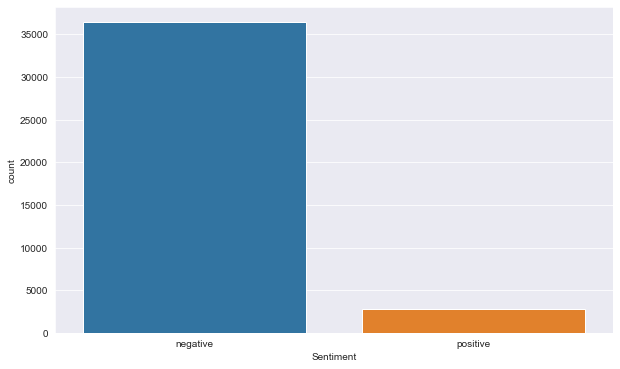

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(x='Sentiment',data=tweets)

<AxesSubplot:xlabel='Emotions', ylabel='count'>

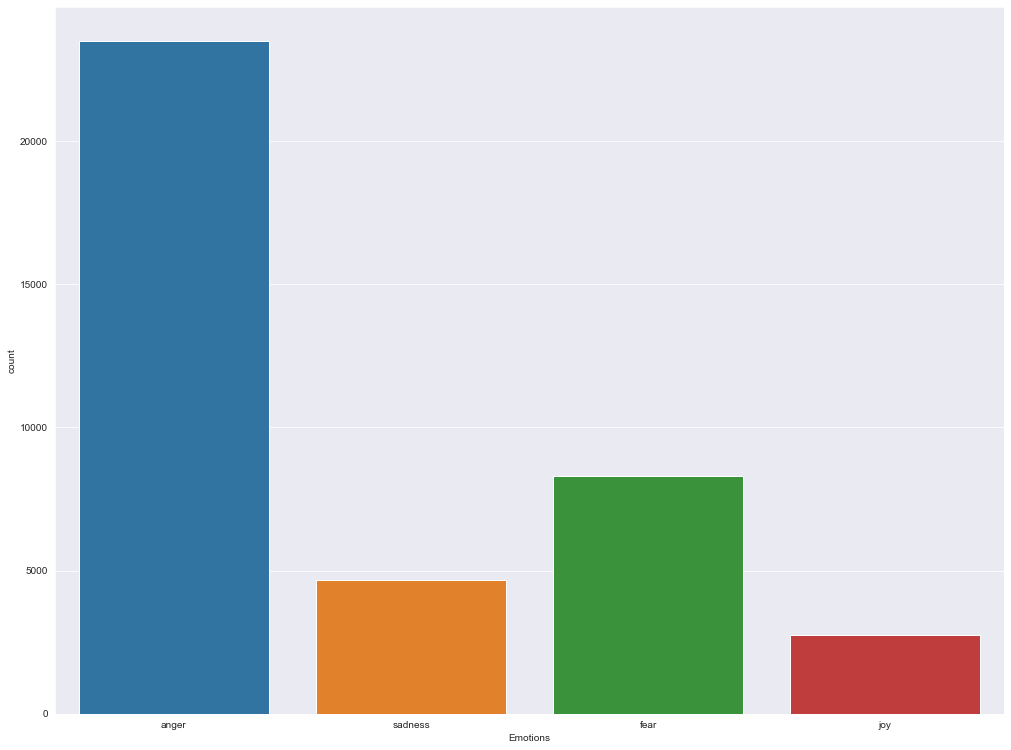

In [11]:
sns.countplot(x='Emotions',data=tweets)

<Figure size 2880x720 with 0 Axes>

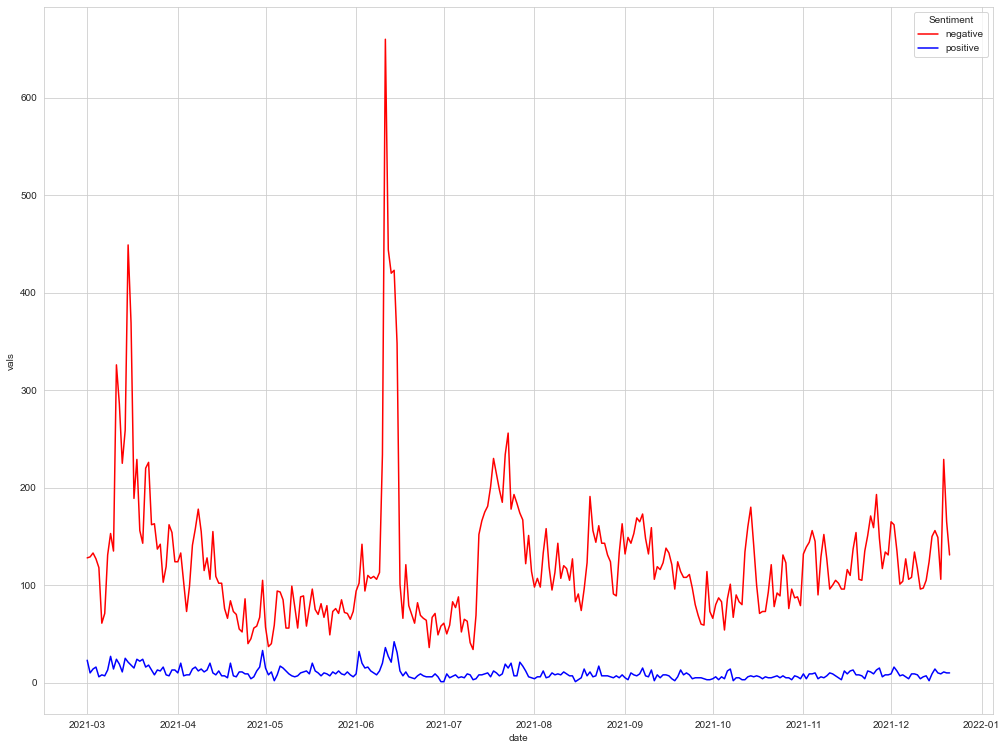

<Figure size 2880x720 with 0 Axes>

In [12]:
tweets["date"] = pd.to_datetime(tweets.date) 
timeline = tweets.resample('D', on='date')["Sentiment"].value_counts().unstack(1)

timeline.reset_index(inplace=True)

timeline = timeline.melt("date", var_name='Sentiment',  value_name='vals')

sns.set_style("whitegrid")
sns.lineplot(x="date", y="vals", hue="Sentiment", data=timeline, palette=["r", "b"])
plt.figure(figsize=(40,10))

The graph above shows the trend of the positive (blue line) and negative (red line) sentiment among the weeks of interest. 
The positive sentiment remains almost stable throughout time, while the negative shows much more variability in intensity.

<Figure size 2880x720 with 0 Axes>

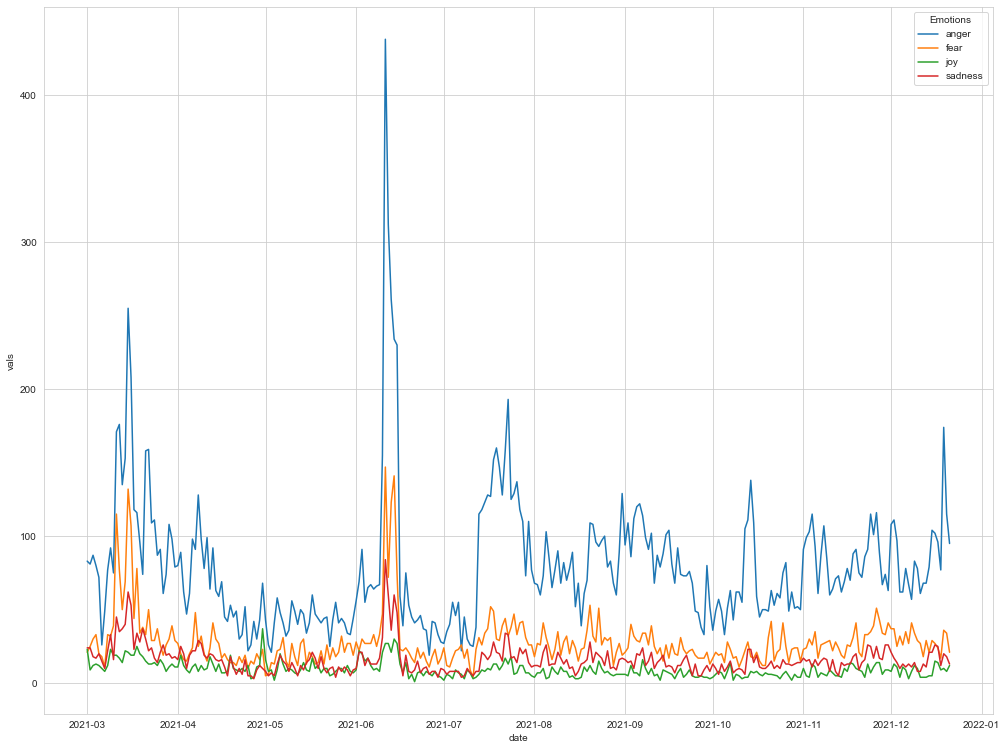

<Figure size 2880x720 with 0 Axes>

In [13]:
tweets["date"] = pd.to_datetime(tweets.date) 
timeline = tweets.resample('D', on='date')["Emotions"].value_counts().unstack(1)

timeline.reset_index(inplace=True)

timeline = timeline.melt("date", var_name='Emotions',  value_name='vals')

sns.set_style("whitegrid")
sns.lineplot(x="date", y="vals", hue="Emotions", data=timeline)
plt.figure(figsize=(40,10))

The graph above shows the trend of the different emotions among the weeks of interest.
As we can note, all registered emotions follow the same trend, with anger being the prevalent one.

<AxesSubplot:title={'center':'Top 5 hashtags'}, ylabel='hashtags'>

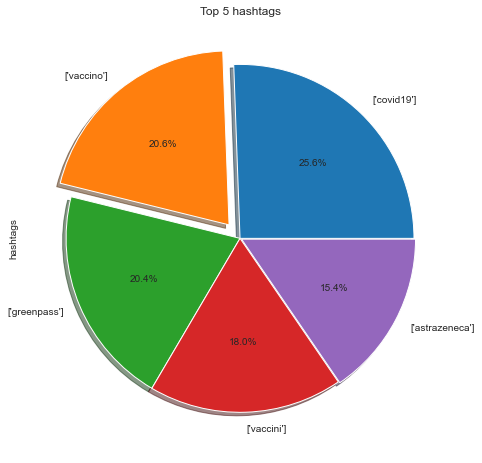

In [14]:
tweets["hashtags"].replace({"[]": np.nan}, inplace = True)  #Some tweets don't have any hashtags, let's replace "[]" with NaNs
tags=tweets['hashtags'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8,8))
explode = (0, 0.1, 0, 0,0.01) 
tags[0:5].plot(kind = 'pie',title = 'Top 5 hashtags',autopct='%1.1f%%',shadow=True,explode = explode)

The graph above shows the portion of the five most used hashtags: as expected, the discussion in the tweets revolves around vaccines, COVID-19 and the greenpass.

## Wordcloud 


In [21]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
stopword = set(stopwords.words('italian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucax\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucax\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Eliminating punctuations

In [17]:
import string
def clean_text(text):
    text = str(text).lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text
tweets['tweet'] = tweets['tweet'].apply(lambda x:clean_text(x))

The function above is escaping all the punctuations starting from text transformed before into lower case. We want to simplify the text mining process as much as possible by removing all the not necessary words or characters.

In [18]:
tweets["tweet"]

0        cmq forzare la gente al vaccino sterminando se...
1        coronavirus israele annuncia inoculazione quar...
2         col nuovo vaccino niente più scuse per i no v...
3        dopo mesi passati a contrapporre vaccino e tam...
4        oh finalmente è uscito il novavax un altro vac...
                               ...                        
39261    tutto i giornali e le tv sono concentrati sul ...
39262    buongiorno ecco laveritàdioggi le fiale ora ci...
39263    dal fallimento della campagna sul vaccino alla...
39264    oggi su laveritaweb intervista a tutto campo a...
39265    parlateci della philipmorris parlateci dei vac...
Name: tweet, Length: 39266, dtype: object

In [19]:
tweets.to_csv("tweets_noPunct.csv", index = False)

### Text prepration

In order to simplify the analysis of most common words, we will apply the steps of the text preparation mentioned above. 
In particular for the tokenization we use re.split wich is a function that splits the source string by the occurrences of the pattern, returning a list containing the resulting substrings.
In particular we specify the special character \W+ since it is a more general version of \w wich matches any alphanumeric character; equivalent to [a-zA-Z0-9_].

After this part we have to remove the stop words. **Stop words** are very common words like 'if', 'but', 'we', 'he', 'she', and 'they'. We can usually remove these words without changing the semantics of a text and doing so often improves the performance of a model.

For the stemming process we use two different functions that applies two different stemming techniques: PorterStemmer and SnowballStemmer. 

Difference Between Porter Stemmer and Snowball Stemmer:

Snowball Stemmer is more aggressive than Porter Stemmer.
Some issues in Porter Stemmer were fixed in Snowball Stemmer.
Words like ‘fairly‘ and ‘sportingly‘ were stemmed to ‘fair’ and ‘sport’ in the snowball stemmer but when you use the porter stemmer they are stemmed to ‘fairli‘ and ‘sportingli‘.
The difference between the two algorithms can be clearly seen in the way the word ‘Sportingly’ in stemmed by both. Clearly Snowball Stemmer stems it to a more accurate stem.


As a last step occour the lemmatization process wich returns the base or dictionary form of a word, also known as the lemma.

In [22]:
df=pd.DataFrame()
df['text']=tweets['tweet']
def tokenization(text):
    text = re.split('\W+', text)
    return text
df['tokenized'] = df['text'].apply(lambda x: tokenization(x.lower()))
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
df['No_stopwords'] = df['tokenized'].apply(lambda x: remove_stopwords(x))
ps = nltk.PorterStemmer()
def stemming1(text):
    text = [ps.stem(word) for word in text]
    return text
df['stemmed_porter'] = df['No_stopwords'].apply(lambda x: stemming1(x))
from nltk.stem.snowball import SnowballStemmer
s_stemmer = SnowballStemmer(language='italian')
def stemming2(text):
    text = [s_stemmer.stem(word) for word in text]
    return text
df['stemmed_snowball'] = df['No_stopwords'].apply(lambda x: stemming2(x))
wn = nltk.WordNetLemmatizer()
def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['lemmatized'] = df['No_stopwords'].apply(lambda x: lemmatizer(x))

In [23]:
df.head(5)

,text,tokenized,No_stopwords,stemmed_porter,stemmed_snowball,lemmatized
0,cmq forzare la gente al vaccino sterminando se...,"[cmq, forzare, la, gente, al, vaccino, stermin...","[cmq, forzare, gente, vaccino, sterminando, se...","[cmq, forzar, gent, vaccino, sterminando, senz...","[cmq, forz, gent, vaccin, stermin, senz, piet,...","[cmq, forzare, gente, vaccino, sterminando, se..."
1,coronavirus israele annuncia inoculazione quar...,"[coronavirus, israele, annuncia, inoculazione,...","[coronavirus, israele, annuncia, inoculazione,...","[coronaviru, israel, annuncia, inoculazion, qu...","[coronavirus, israel, annunc, inocul, quart, d...","[coronavirus, israele, annuncia, inoculazione,..."
2,col nuovo vaccino niente più scuse per i no v...,"[, col, nuovo, vaccino, niente, più, scuse, pe...","[, nuovo, vaccino, niente, scuse, no, vax, qui...","[, nuovo, vaccino, nient, scuse, no, vax, quin...","[, nuov, vaccin, nient, scus, no, vax, quind, ...","[, nuovo, vaccino, niente, scuse, no, vax, qui..."
3,dopo mesi passati a contrapporre vaccino e tam...,"[dopo, mesi, passati, a, contrapporre, vaccino...","[dopo, mesi, passati, contrapporre, vaccino, t...","[dopo, mesi, passati, contrapporr, vaccino, ta...","[dop, mes, pass, contrapporr, vaccin, tampon, ...","[dopo, mesi, passati, contrapporre, vaccino, t..."
4,oh finalmente è uscito il novavax un altro vac...,"[oh, finalmente, è, uscito, il, novavax, un, a...","[oh, finalmente, uscito, novavax, altro, vacci...","[oh, finalment, uscito, novavax, altro, vaccin...","[oh, final, uscit, novavax, altro, vaccin, ant...","[oh, finalmente, uscito, novavax, altro, vacci..."


In [24]:
tweets["lemmatized"] = df['lemmatized']
tweets.head(5)

,date,time,username,tweet,language,mentions,replies_count,retweets_count,likes_count,hashtags,Sentiment,Emotions,lemmatized
0,2021-12-21,23:47:42,cris_cersei,cmq forzare la gente al vaccino sterminando se...,it,[],14,97,465,NaN,negative,anger,"[cmq, forzare, gente, vaccino, sterminando, se..."
1,2021-12-21,23:37:18,astramezzi,coronavirus israele annuncia inoculazione quar...,it,[],64,325,856,NaN,negative,anger,"[coronavirus, israele, annuncia, inoculazione,..."
2,2021-12-21,23:30:45,gavinosanna1967,col nuovo vaccino niente più scuse per i no v...,it,[],56,206,1208,NaN,negative,anger,"[, nuovo, vaccino, niente, scuse, no, vax, qui..."
3,2021-12-21,23:17:15,vitalbaa,dopo mesi passati a contrapporre vaccino e tam...,it,[],31,49,383,NaN,negative,anger,"[dopo, mesi, passati, contrapporre, vaccino, t..."
4,2021-12-21,22:59:08,christian_fsi,oh finalmente è uscito il novavax un altro vac...,it,[],16,44,231,['novavax'],negative,anger,"[oh, finalmente, uscito, novavax, altro, vacci..."


In [25]:
tweets.to_csv("tweets_lemmatized.csv", index = False)

In [26]:
tweets = pd.read_csv("tweets_lemmatized.csv")

In [27]:
tweets.head(5)

,date,time,username,tweet,language,mentions,replies_count,retweets_count,likes_count,hashtags,Sentiment,Emotions,lemmatized
0,2021-12-21,23:47:42,cris_cersei,cmq forzare la gente al vaccino sterminando se...,it,[],14,97,465,NaN,negative,anger,"['cmq', 'forzare', 'gente', 'vaccino', 'stermi..."
1,2021-12-21,23:37:18,astramezzi,coronavirus israele annuncia inoculazione quar...,it,[],64,325,856,NaN,negative,anger,"['coronavirus', 'israele', 'annuncia', 'inocul..."
2,2021-12-21,23:30:45,gavinosanna1967,col nuovo vaccino niente più scuse per i no v...,it,[],56,206,1208,NaN,negative,anger,"['', 'nuovo', 'vaccino', 'niente', 'scuse', 'n..."
3,2021-12-21,23:17:15,vitalbaa,dopo mesi passati a contrapporre vaccino e tam...,it,[],31,49,383,NaN,negative,anger,"['dopo', 'mesi', 'passati', 'contrapporre', 'v..."
4,2021-12-21,22:59:08,christian_fsi,oh finalmente è uscito il novavax un altro vac...,it,[],16,44,231,['novavax'],negative,anger,"['oh', 'finalmente', 'uscito', 'novavax', 'alt..."


We create a wordcloud with the prevalents words in tweets after lemmatization.
We use regex to eliminate the punctuations so we have a clean string for each tweet.
Then we simply append each string so we create a single big string so wordcloud can process it.


**Most twitted words**

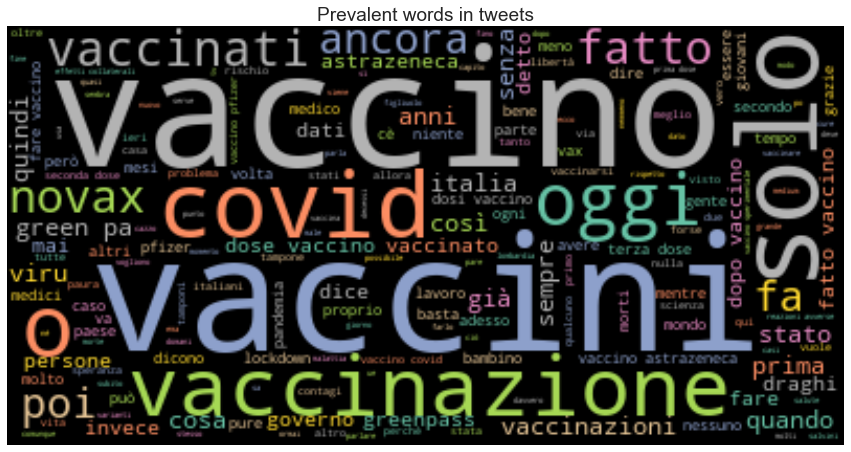

In [28]:
string = ""
for i in range(len(tweets["lemmatized"])):
    single = re.sub(r'[^\w\s]','',tweets["lemmatized"][i])
    string += single
    
#text = ",".join(review for review in tweets.tweet if 'COVID' not in review and 'https' not in review and 'Covid' not in review)
wordcloud = WordCloud(colormap='Set2', background_color="black").generate(string)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.figure(1,figsize=(12, 12))
plt.title('Prevalent words in tweets',fontsize=19)
plt.show()


To see the most common words in Tweets we create a list with every word. In order to find the most common words we use the lemmatized column were we have single words without prefixes.
As in all the cases above we use the same regex function to clean a set of characters represented by the special characters \w and \s.

In this case that the words 'vaccino' and  'covid' are the most present among the tweets, this result was expected since the scraping process was based on the words vaccino, vaccini, vaccianazioni and vaccinazione.